<a href="https://colab.research.google.com/github/qmeng222/transformers-for-NLP/blob/main/QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answering with SQuAD (Stanford Question Answering Dataset) 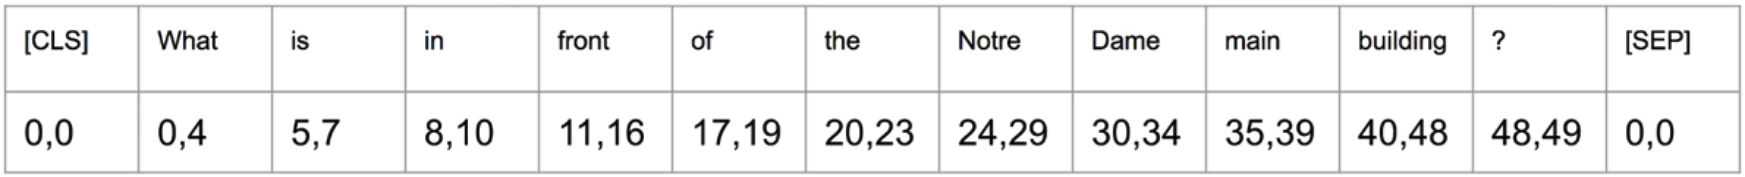

In [1]:
# install libraries:
!pip install transformers datasets
# `transformers` library: for using pre-trained models
# `datasets` library: to access a collection of high-quality datasets for NLP tasks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00


# Load & explore the SQuAD dataset:

In [2]:
from datasets import load_dataset # import the function

# load the dataset:
raw_datasets = load_dataset("squad")
raw_datasets

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

👆 **train** and **validation** subsets

In [3]:
# explore the train subset:
raw_datasets["train"][1]

{'id': '5733be284776f4190066117f',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'What is in front of the Notre Dame Main Building?',
 'answers': {'text': ['a copper statue of Christ'], 'answer_start': [188]}}

👆 5 fields: 'id', 'title', 'context', 'question', 'answers'

'answers' has 'text' and  'answer_start' idx

In [4]:
# just to make sure each sample in the training has only 1 answer (no multi answers, or no anwers):
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Filter:   0%|          | 0/87599 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

👆 Great, num_rows:0

(training set) for each question, there's only 1 answer

In [5]:
# explore the devset (validation subset):
# for validation set, there might be multiple answers
raw_datasets["validation"][2]

{'id': '56be4db0acb8001400a502ee',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Where did Super Bowl 50 take place?',
 'answers': {'text': ['Santa Clara, California',
   "Levi's Stadium",
   "Levi's Stadium in th

👆 (devset) for a single question, there might be multiple right answers  

In [6]:
# in devset, the answers for a single question might even be the same:
raw_datasets["validation"][0]

{'id': '56be4db0acb8001400a502ec',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Which NFL team represented the AFC at Super Bowl 50?',
 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],


👆 'answers': {
                'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
                'answer_start': [177, 177, 177]
              }

# Load tokenizer:

In [7]:
from transformers import AutoTokenizer # import the class, enabling dynamic loading of tokenizer for a specific pre-trained model

checkpoint = "distilbert-base-cased" # model identifier (specify the name of a pre-trained model)
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # automatically load the appropriate tokenizer

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

# Test the tokenizer:

In [8]:
# examine a sample from the training data:
raw_datasets["train"][1]

{'id': '5733be284776f4190066117f',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'What is in front of the Notre Dame Main Building?',
 'answers': {'text': ['a copper statue of Christ'], 'answer_start': [188]}}

In [9]:
# params:
question = raw_datasets["train"][1]["question"]
context = raw_datasets["train"][1]["context"]

# tokenize both the question and the context:
inputs = tokenizer(question, context)
inputs

{'input_ids': [101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 10595, 2430, 117, 170, 14789, 1282, 1104, 8070, 1105, 9284, 119, 1135, 1110, 170, 16498, 1104, 1103, 176, 10595, 2430, 1120, 10111, 20500, 117, 1699, 1187, 1103, 6567, 2090, 25153, 1193, 1691, 1106, 2216, 17666, 6397, 3786, 1573, 25422, 13149, 1107, 8109, 119, 1335, 1103, 1322, 1104, 1103, 1514, 2797, 113, 1105, 1107, 170, 2904, 1413, 1115, 8200, 1194, 124, 11739, 1105, 1103, 3487, 17917, 114, 117

In [10]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [11]:
# use the tokenizer to convert a sequence of token IDs back into human-readable text:
tokenizer.decode(inputs["input_ids"])

'[CLS] What is in front of the Notre Dame Main Building? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

👆 The **question** and **context** are concatenated into one string.

# Split long context into multiple (overlapping) windows:

In [12]:
inputs = tokenizer(
  question,
  context,
  max_length=100, # the max length of the resulting tokenized sequence (truncate or pad the sequence accordingly)
  truncation="only_second", # only 'context' will be truncated if the tokenized seq length exceeds max_length; 'question' will be left untouched
  stride=50, # if the combined length of the tokenized question and context exceeds max_length, the tokenizer will create overlapping chunks with a stride of 50 tokens (overlapping prev chunk by 50 tokens)
  return_overflowing_tokens=True, # tokenizer returns the remaining tokens that couldn't fit within the specified length
)

inputs

{'input_ids': [[101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 102], [101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 10595, 2430, 117, 1

In [13]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping'])

👆 This time, 'overflow_to_sample_mapping' was introduced due to the `return_overflowing_tokens=True` setting.

NOTE: 101 and 102 are special tokens denoting the beginning and end of a sequence.

In [17]:
# what's the new key?
inputs['overflow_to_sample_mapping']

[0, 0, 0, 0]

In [16]:
inputs["input_ids"]

[[101,
  1327,
  1110,
  1107,
  1524,
  1104,
  1103,
  10360,
  8022,
  4304,
  4334,
  136,
  102,
  22182,
  1193,
  117,
  1103,
  1278,
  1144,
  170,
  2336,
  1959,
  119,
  1335,
  4184,
  1103,
  4304,
  4334,
  112,
  188,
  2284,
  10945,
  1110,
  170,
  5404,
  5921,
  1104,
  1103,
  6567,
  2090,
  119,
  13301,
  1107,
  1524,
  1104,
  1103,
  4304,
  4334,
  1105,
  4749,
  1122,
  117,
  1110,
  170,
  7335,
  5921,
  1104,
  4028,
  1114,
  1739,
  1146,
  14089,
  5591,
  1114,
  1103,
  7051,
  107,
  159,
  21462,
  1566,
  24930,
  2508,
  152,
  1306,
  3965,
  107,
  119,
  5893,
  1106,
  1103,
  4304,
  4334,
  1110,
  1103,
  19349,
  1104,
  1103,
  11373,
  4641,
  119,
  13301,
  1481,
  1103,
  171,
  17506,
  9538,
  1110,
  1103,
  144,
  102],
 [101,
  1327,
  1110,
  1107,
  1524,
  1104,
  1103,
  10360,
  8022,
  4304,
  4334,
  136,
  102,
  4749,
  1122,
  117,
  1110,
  170,
  7335,
  5921,
  1104,
  4028,
  1114,
  1739,
  1146,
  14089,
  55

👆 List of lists. Each sublist begins with the token 101 and ends with the token 102.

In [15]:
for ids in inputs["input_ids"]:
  print(tokenizer.decode(ids)) # use the tokenizer to convert a sequence of token IDs back into human-readable text

[CLS] What is in front of the Notre Dame Main Building? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the G [SEP]
[CLS] What is in front of the Notre Dame Main Building? [SEP] facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernade [SEP]
[CLS] What is in front of the Notre Dame Main Building? [SEP] of the Sacred Heart. Immediately behind the basilica is the Grotto, 

# Actual tokenizer call:

In [18]:
inputs = tokenizer(
    raw_datasets["train"][:3]["question"], # extract questions from the first 3 training samples
    raw_datasets["train"][:3]["context"], # extract contexts from the first 3 training samples
    max_length=100, # the max length of the resulting tokenized sequence (truncate or pad the sequence accordingly)
    truncation="only_second", # only 'context' will be truncated if the tokenized seq length exceeds max_length; 'question' will be left untouched
    stride=50, # if the combined length of the tokenized question and context exceeds max_length, the tokenizer will create overlapping chunks with a stride of 50 tokens (overlapping prev chunk by 50 tokens)
    return_overflowing_tokens=True, # tokenizer returns remaining tokens that couldn't fit within max_length
    return_offsets_mapping=True, # tokenizer returns character offsets mapping for each token
)

inputs

{'input_ids': [[101, 1706, 2292, 1225, 1103, 6567, 2090, 9273, 2845, 1107, 8109, 1107, 10111, 20500, 1699, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 102], [101, 1706, 2292, 1225, 1103, 6567, 2090, 9273, 2845, 1107, 8109, 1107, 10111, 20500, 1699, 136, 102, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171

In [20]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

👆 2 new keys


# Check the two new keys:

***Example:***

Original Text: "The quick brown fox."

Tokenized Tokens: ["The", "quick", "brown", "fox", "."]

***Offset mapping associates each token with its start and end character offsets in the original text:***

Offset Mapping: [(0, 3), (4, 9), (10, 15), (16, 19), (20, 21)]

In [27]:
# 1. inspect the value associated with the 'offset_mapping' key:
inputs['offset_mapping']

[[(0, 0),
  (0, 2),
  (3, 7),
  (8, 11),
  (12, 15),
  (16, 22),
  (23, 27),
  (28, 37),
  (38, 44),
  (45, 47),
  (48, 52),
  (53, 55),
  (56, 59),
  (59, 63),
  (64, 70),
  (70, 71),
  (0, 0),
  (0, 13),
  (13, 15),
  (15, 16),
  (17, 20),
  (21, 27),
  (28, 31),
  (32, 33),
  (34, 42),
  (43, 52),
  (52, 53),
  (54, 56),
  (56, 58),
  (59, 62),
  (63, 67),
  (68, 76),
  (76, 77),
  (77, 78),
  (79, 83),
  (84, 88),
  (89, 91),
  (92, 93),
  (94, 100),
  (101, 107),
  (108, 110),
  (111, 114),
  (115, 121),
  (122, 126),
  (126, 127),
  (128, 139),
  (140, 142),
  (143, 148),
  (149, 151),
  (152, 155),
  (156, 160),
  (161, 169),
  (170, 173),
  (174, 180),
  (181, 183),
  (183, 184),
  (185, 187),
  (188, 189),
  (190, 196),
  (197, 203),
  (204, 206),
  (207, 213),
  (214, 218),
  (219, 223),
  (224, 226),
  (226, 229),
  (229, 232),
  (233, 237),
  (238, 241),
  (242, 248),
  (249, 250),
  (250, 251),
  (251, 254),
  (254, 256),
  (257, 259),
  (260, 262),
  (263, 264),
  (264, 2

👆 List of lists of tuples.

(0, 0) -> [CLS] and [SEP]

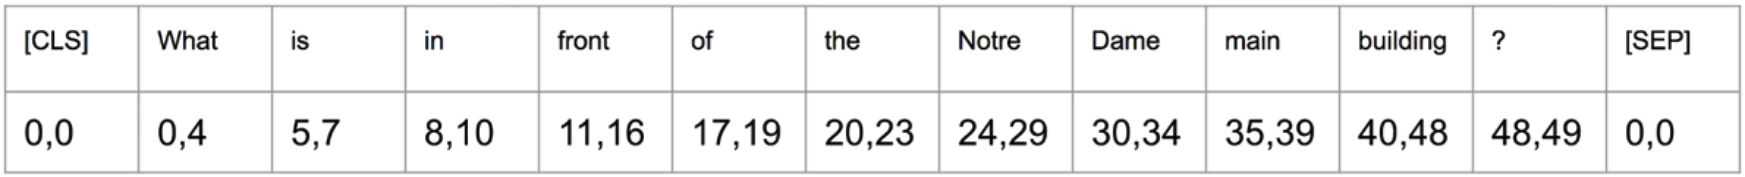

In [25]:
len(inputs['offset_mapping']) # 12 sub-lists

12

In [26]:
len(inputs['offset_mapping'][0]) # the first sub-list consists 100 tuples

100

👆 max_length=100

In [29]:
len(inputs['offset_mapping'][11]) # the last sub-list only consists 85 tuples

85

👆 Some inputs may not be of size 100, as 'return_overflowing_tokens=True' includes additional tokens that couldn't fit within the specified length.

In [28]:
# 2. inspect the value associated with the 'overflow_to_sample_mapping' key:
inputs['overflow_to_sample_mapping']

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]